In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import xmltodict
import random
from os import listdir
from os.path import isfile, join
import torchvision
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [29]:
def getImageNames():
    image_names = []
    for dirname, _, filenames in os.walk('./face_mask_detection_data'):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            extension = fullpath[len(fullpath) - 4:]
            if extension == '.png':
                image_names.append(filename)
    return image_names

def get_path(image_name):
    home_path = './face_mask_detection_data/'
    image_path = home_path + 'images/' + image_name
    
    if image_name[-4:] == 'jpeg':
        label_name = image_name[:-5] + '.xml'
    else:
        label_name = image_name[:-4] + '.xml'
        
    label_path = home_path + 'annotations/' + label_name
    
    return image_path, label_path

In [30]:
def parse_xml(label_path):
    x = xmltodict.parse(open(label_path , 'rb'))
    item_list = x['annotation']['object']
    
    # when image has only one bounding box
    if not isinstance(item_list, list):
        item_list = [item_list]
        
    result = []
    
    for item in item_list:
        name = item['name']
        bndbox = [(int(item['bndbox']['xmin']), int(item['bndbox']['ymin'])),
                  (int(item['bndbox']['xmax']), int(item['bndbox']['ymax']))]       
        result.append((name, bndbox))
    
    size = [int(x['annotation']['size']['width']), 
            int(x['annotation']['size']['height'])]
    
    return result, size


def visualize_image(image_name, bndbox=True):
    
    #CREDIT: kaggle.com/dohunkim
    
    
    image_path, label_path = get_path(image_name)
    
    image = cv2.imread(image_path)
    print(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if bndbox:
        labels, size = parse_xml(label_path)
        thickness = int(sum(size)/400.)
        
        for label in labels:
            name, bndbox = label
            
            if name == 'with_mask':
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 255, 0), thickness)
            elif name == 'without_mask':
                cv2.rectangle(image, bndbox[0], bndbox[1], (255, 0, 0), thickness)
            else: # name == 'none'
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 0, 255), thickness)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(image_name)
    plt.imshow(image)
    plt.show()

In [31]:
image_names = getImageNames()
image_names[:4]

['maksssksksss0.png',
 'maksssksksss1.png',
 'maksssksksss10.png',
 'maksssksksss100.png']

./face_mask_detection_data/images/maksssksksss0.png ./face_mask_detection_data/annotations/maksssksksss0.xml
./face_mask_detection_data/images/maksssksksss0.png


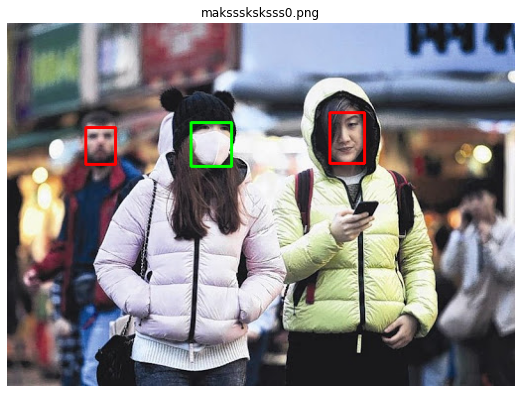

In [32]:
image_path, label_path = get_path(image_names[0])
print(image_path, label_path)
visualize_image(image_names[0])

In [33]:
NUM_OF_IMGS_TO_VISUALIZE = 1
%matplotlib inline
for i in range(5, NUM_OF_IMGS_TO_VISUALIZE):
    visualize_image(image_names[i])

In [34]:
def cropImage(image_name):
    image_path, label_path = get_path(image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    
    labels, size = parse_xml(label_path)
    
    cropedImgLabels = []

    for label in labels:
        name, bndbox = label
        
        
        croped_image = image[bndbox[0][1]:bndbox[1][1], bndbox[0][0]:bndbox[1][0]]
        
        label_num = 0
        
        if name == "without_mask":
            label_num = 1
        else:
            label_num = 0
        
        cropedImgLabel = [croped_image, label_num]
        
        cropedImgLabels.append(cropedImgLabel)
        
    return cropedImgLabels

In [35]:
def createDirectory(dirname):
    try:
        os.mkdir(dirname)
    except FileExistsError:
        print("Directory " + dirname + " already exists.")

In [36]:
dir_name = 'train/'
label_0_dir = dir_name + "0/"
label_1_dir = dir_name + "1/"
label_2_dir = dir_name + "2/"
models_dir = "models/"


createDirectory(dir_name)
createDirectory(label_0_dir)
createDirectory(label_1_dir)
createDirectory(label_2_dir)
createDirectory(models_dir)

Directory train/ already exists.
Directory train/0/ already exists.
Directory train/1/ already exists.
Directory train/2/ already exists.
Directory models/ already exists.


In [37]:
label_0_counter = 0
label_1_counter = 0
label_2_counter = 0

for image_name in image_names:
    cropedImgLabels = cropImage(image_name)
    
    for cropedImgLabel in cropedImgLabels:
        
        label = cropedImgLabel[1]
        img = cropedImgLabel[0]
        
        if label == 0:
            croped_img_name = str(label_0_counter) + ".jpg"
            cv2.imwrite(label_0_dir + croped_img_name, img)
            label_0_counter += 1
        elif label == 1:
            croped_img_name = str(label_1_counter) + ".jpg"
            cv2.imwrite(label_1_dir + croped_img_name, img)
            label_1_counter += 1
        else:
            croped_img_name = str(label_2_counter) + ".jpg"
            cv2.imwrite(label_2_dir + croped_img_name, img)
            label_2_counter += 1

In [38]:
filenames_label_0 = [f for f in listdir(label_0_dir) if isfile(join(label_0_dir, f))]
filenames_label_1 = [f for f in listdir(label_1_dir) if isfile(join(label_1_dir, f))]
onlyfiles_2 = [f for f in listdir(label_2_dir) if isfile(join(label_2_dir, f))]

In [39]:
print("Total number of images: " + str(len(filenames_label_0) + len(filenames_label_1)))
print("Number of images labeled 0: " + str(len(filenames_label_0)))
print("Number of images labeled 1: " + str(len(filenames_label_1)))
print("Number of images labeled 2: " + str(len(onlyfiles_2)))

Total number of images: 4072
Number of images labeled 0: 3355
Number of images labeled 1: 717
Number of images labeled 2: 0


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [56]:
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [57]:
for layer, param in model.named_parameters():
    
    if 'layer4' not in layer:
        param.requires_grad = False

model.fc = torch.nn.Sequential(torch.nn.Linear(2048, 512),
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(0.2),
                                 torch.nn.Linear(512, 2),
                                 torch.nn.LogSoftmax(dim=1))

In [58]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])

In [59]:
dataset = datasets.ImageFolder(dir_name, transform = train_transforms)

dataset_size = len(dataset)
train_size = int(dataset_size * 0.6)
val_size = int(dataset_size * 0.2)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

print('Dataset size: ', len(dataset))
print('Train set size: ', len(train_dataset))
print('Validation set size: ', len(val_dataset))
print('Test set size: ', len(test_dataset))

Dataset size:  4072
Train set size:  2443
Validation set size:  814
Test set size:  815


In [60]:
BATCH_SIZE = 20

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

In [61]:
LEARNING_RATE = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [62]:
#model.cuda()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [48]:
total_epoch = 20

best_epoch = 0
training_losses = []
val_losses = []


for epoch in range(total_epoch):
    
    epoch_train_loss = 0
    
    for X, y in train_loader:
        
        X, y = X.cuda(), y.cuda()
        
        optimizer.zero_grad()
        result = model(X)
        loss = criterion(result, y)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
      
    training_losses.append(epoch_train_loss)
    
    
    epoch_val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in val_loader:
            
            X, y = X.cuda(), y.cuda()
             
            result = model(X)
            loss = criterion(result, y)
            epoch_val_loss += loss.item()
            _, maximum = torch.max(result.data, 1)
            total += y.size(0)
            correct += (maximum == y).sum().item()
            
    val_losses.append(epoch_val_loss)
    accuracy = correct/total
    print("EPOCH:", epoch, ", Training Loss:", epoch_train_loss, ", Validation Loss:", epoch_val_loss, ", Accuracy: ", accuracy)
    
    
    if min(val_losses) == val_losses[-1]:
        best_epoch = epoch
        checkpoint = {'model': model,
                            'state_dict': model.state_dict(),
                            'optimizer' : optimizer.state_dict()}

        torch.save(checkpoint, models_dir + '{}.pth'.format(epoch))
        print("Model saved")

EPOCH: 0 , Training Loss: 23.166730489116162 , Validation Loss: 4.171682620421052 , Accuracy:  0.9631449631449631
Model saved
EPOCH: 1 , Training Loss: 9.862362716638017 , Validation Loss: 3.9739920659922063 , Accuracy:  0.961916461916462
Model saved
EPOCH: 2 , Training Loss: 5.947427746141329 , Validation Loss: 5.822670450434089 , Accuracy:  0.9484029484029484
EPOCH: 3 , Training Loss: 5.525488182938716 , Validation Loss: 2.9686838902998716 , Accuracy:  0.9742014742014742
Model saved
EPOCH: 4 , Training Loss: 4.165753115870757 , Validation Loss: 3.0849232329346705 , Accuracy:  0.9815724815724816
EPOCH: 5 , Training Loss: 3.0863632616528776 , Validation Loss: 3.3717631556792185 , Accuracy:  0.9717444717444718
EPOCH: 6 , Training Loss: 2.680196326593432 , Validation Loss: 3.1976537879236275 , Accuracy:  0.9791154791154791
EPOCH: 7 , Training Loss: 4.216118260126677 , Validation Loss: 4.620606081734877 , Accuracy:  0.9754299754299754
EPOCH: 8 , Training Loss: 1.5253153958292387 , Validat

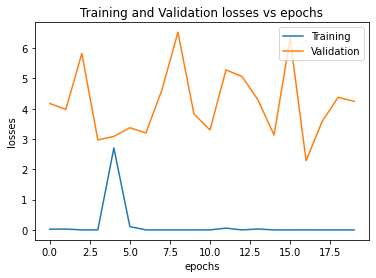

In [66]:
plt.plot(range(total_epoch), training_losses, label='Training')
plt.plot(range(total_epoch), val_losses, label='Validation')
plt.xlabel("epochs")
plt.ylabel("losses")
plt.title("Training and Validation losses vs epochs")
plt.legend()

Directory maskModels/ already exists.
Epoch 1 Train loss: 0.024.. Test loss: 0.102.. Test accuracy: 0.968
Model saved
Epoch 2 Train loss: 0.029.. Test loss: 0.095.. Test accuracy: 0.970
Model saved
Epoch 3 Train loss: 0.000.. Test loss: 0.087.. Test accuracy: 0.967
Model saved
Epoch 4 Train loss: 0.001.. Test loss: 0.091.. Test accuracy: 0.975
Epoch 5 Train loss: 2.701.. Test loss: 0.072.. Test accuracy: 0.973
Model saved
Epoch 6 Train loss: 0.109.. Test loss: 0.099.. Test accuracy: 0.967
Epoch 7 Train loss: 0.000.. Test loss: 0.102.. Test accuracy: 0.975
Epoch 8 Train loss: 0.000.. Test loss: 0.140.. Test accuracy: 0.968
Epoch 9 Train loss: 0.000.. Test loss: 0.136.. Test accuracy: 0.970
Epoch 10 Train loss: 0.000.. Test loss: 0.132.. Test accuracy: 0.966
Epoch 11 Train loss: 0.001.. Test loss: 0.113.. Test accuracy: 0.978
Epoch 12 Train loss: 0.060.. Test loss: 0.111.. Test accuracy: 0.971
Epoch 13 Train loss: 0.000.. Test loss: 0.133.. Test accuracy: 0.976
Epoch 14 Train loss: 0.031

ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

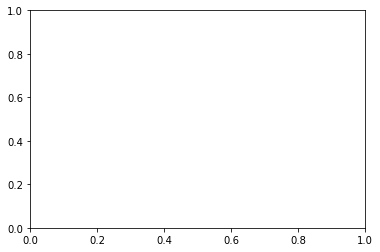

In [6]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()

models_dir = "models/"
# filepath = models_dir + str(best_epoch) + ".pth"
filepath = models_dir + str(15)+".pth"
loaded_model = load_checkpoint(filepath)
print(filepath)

train_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

models/15.pth


In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()

models_dir = "maskModels/"
# filepath = models_dir + str(best_epoch) + ".pth"
filepath = models_dir + str(15)+".pth"
loaded_model = load_checkpoint(filepath)
print(filepath)

train_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                       ])

In [30]:
correct = 0
total = 0
    
with torch.no_grad():
    for X, y in test_loader:

        X, y = X.cuda(), y.cuda()

        result = loaded_model(X)
        _, maximum = torch.max(result.data, 1)
        total += y.size(0)
        correct += (maximum == y).sum().item()

accuracy = correct/total

print("\n")
print("------------")
print("Accuracy: " + str(accuracy))
print("------------")
print("\n")



------------
Accuracy: 0.9766871165644172
------------




In [1]:
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import argparse
import numpy as np

root_path = './'
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-f", "--face", type=str,
    default="face_detector",
    help="path to face detector model directory")
ap.add_argument("-m", "--model", type=str,
    default="mask_detector.model",
    help="path to trained face mask detector model")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
    help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

prototxtPath = root_path + 'face_detector/deploy.prototxt'
weightsPath = root_path + 'face_detector/res10_300x300_ssd_iter_140000.caffemodel'
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

print("[INFO] starting video stream...")

cap = cv2.VideoCapture(0)

font_scale=1
thickness = 2
red = (0,0,255)
green = (0,255,0)
blue = (255,0,0)
font=cv2.FONT_HERSHEY_SIMPLEX

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frame = cv2.flip(frame,1)
        (h, w) = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
            (104.0, 177.0, 123.0))

        # pass the blob through the network and obtain the face detections
        faceNet.setInput(blob)
        detections = faceNet.forward()

        # initialize our list of faces, their corresponding locations,
        # and the list of predictions from our face mask network
        faces = []
        locs = []
        preds = []
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#         faces = face_cascade.detectMultiScale(gray, 1.4, 4)
        for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
            confidence = detections[0, 0, i, 2]

            # filter out weak detections by ensuring the confidence is
            # greater than the minimum confidence
            if confidence > args["confidence"]:
                # compute the (x, y)-coordinates of the bounding box for
                # the object
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                # ensure the bounding boxes fall within the dimensions of
                # the frame
                (startX, startY) = (max(0, startX), max(0, startY))
                (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

                # extract the face ROI, convert it from BGR to RGB channel
                # ordering, resize it to 224x224, and preprocess it
                face = frame[startY:endY, startX:endX]
                face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                face = cv2.resize(face, (224, 224))
                face = img_to_array(face)
                face = preprocess_input(face)

                # add the face and bounding boxes to their respective
                # lists
                faces.append(face)
                locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
        if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
            faces = np.array(faces, dtype="float32")
            
            for (startX, startY, endX, endY) in locs:
            
                croped_img = frame[startY:endY, startX:endX]
                pil_image = Image.fromarray(croped_img, mode = "RGB")
                pil_image = train_transforms(pil_image)
                image = pil_image.unsqueeze(0)
                image = image.to(device)

                result = loaded_model(image)
                _, maximum = torch.max(result.data, 1)
                (mask, withoutMask) = result.data[0]
                prediction = maximum.item()
                
                label = "MASK" if mask > withoutMask else "NO MASK"
                color = (0, 255, 0) if label == "MASK" else (0, 0, 255)

                # include the probability in the label
                label = "{}: {:.2f}%".format(label, 100+max(mask, withoutMask) * 100)

            
                if prediction == 0:
                    cv2.putText(frame, label, (startX,startY - 10), font, font_scale, green, thickness)
                    cv2.putText(frame, "PLEASE ENTER", (startX, endY+20), font, font_scale, green, thickness)
                    cv2.rectangle(frame, (startX, startY), (endX, endY), green, 2)
                elif prediction == 1:
                    cv2.putText(frame, label, (startX,startY - 10), font, font_scale, red, thickness)
                    cv2.putText(frame, "STOP: MASK REQUIRED", (startX, endY+25), font, font_scale, red, thickness)
                    cv2.rectangle(frame, (startX, startY), (endX, endY), red, 2)
        
        cv2.imshow('frame',frame)
        
        if (cv2.waitKey(1) & 0xFF) == ord('q'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [22]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os

def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
        (104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()

    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > args["confidence"]:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-f", "--face", type=str,
    default="face_detector",
    help="path to face detector model directory")
ap.add_argument("-m", "--model", type=str,
    default="mask_detector.model",
    help="path to trained face mask detector model")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
    help="minimum probability to filter weak detections")
args = vars(ap.parse_args())
root_path = './'

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")

prototxtPath = root_path + '/face_detector/deploy.prototxt'
weightsPath = root_path + 'face_detector/res10_300x300_ssd_iter_140000.caffemodel'
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model(args["model"])

# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
vs = VideoStream(src=1).start()
time.sleep(2.0)

roi_top= 30
roi_bottom = 350
roi_left = 80
roi_right = 350

# loop over the frames from the video stream
while True:
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
    frame = vs.read()
    frame = cv2.flip(frame,1)
    frame = imutils.resize(frame, width=400)
    cv2.rectangle(frame, (roi_left,roi_top), (roi_right,roi_bottom), (255,0,0),2)

    # detect faces in the frame and determine if they are wearing a
    # face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

    # loop over the detected face locations and their corresponding
    # locations
    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(frame, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    # show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] starting video stream...
